**Grupo 2**

**Esteban Neira Mejía - 1010010026**

**Mateo Cardona - 1193460101**

**Juan Diego Castaño -1002634927**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##Clases

In [ ]:
# Clase FullyConnected Layer

class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)    # Inicialización de Glorot - Normaliza los valores para que queden en un rango óptimo
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)     

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        input = self.input
        if (len(input.shape) != len((32,1))):
          input = input[:,np.newaxis]
          weights_error = np.dot(input,output_error)
        else:  
          weights_error = np.dot(input.T, output_error)
        # bias_error = output_error
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [ ]:
# Clase Capa de Activación

class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [ ]:
# Algunas funciones de activación

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x,0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

def leaky_relu(x):
    return np.maximum(0.01*x,x)

def leaky_relu_prime(x):
    return np.array(0.01*x >= 0).astype('int')

In [ ]:
# Funciones de costo

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def mae_prime(y_true, y_pred):
    N = y_true.shape[0]
    return -((y_true - y_pred) / (abs(y_true - y_pred) + 10**-100))/N     

## Importación y Preprocesamiento de Datos

El siguiente conjunto de datos ha sido obtenido por una compañía de energía que tiene un generador al cual se le han extraído los siguientes atributos:

* Temperatura ambiente (AT)
* Vacío en el Exhosto (V)
* Presión Ambiente (AP)
* Humedad Relativa (RH)

La última columna es la Potencia obtenida (PE) por el generador con los atributos mencionados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

dataSet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizaje de Máquina/Datos/datos_energia.csv')

<Axes: >

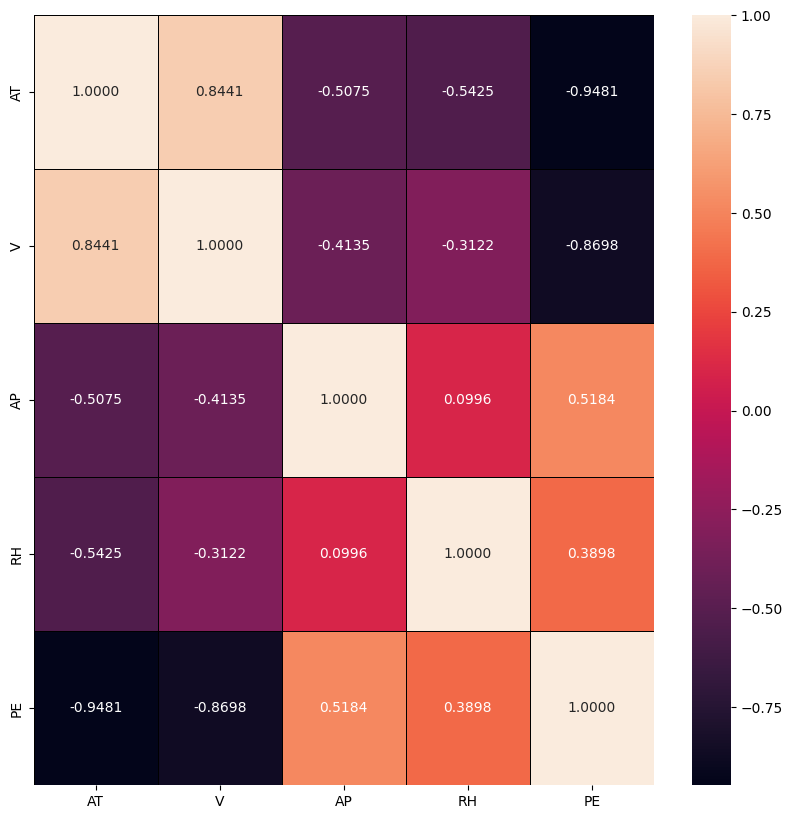

In [ ]:
# Realizamos un mapa de calor con las correlaciones de las variables para determinar con cuales es mejor trabajar.

f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(dataSet.corr(), annot=True, linewidths=0.5, linecolor= 'black', fmt= '.4f', ax= ax)

Las variables Temperatura Ambiente (AT) y Vacío en el Exhosto (V) son las que mejor se relacionan con la variable a predecir Potencia Obtenida (PE)

In [ ]:
# se toman las 2 primeras columnas como las variables de entrada X
X = dataSet.iloc[:, 0:2].values

# se toma la última columna como la variable de salida y
y = dataSet.iloc[:,-1].values

Visualizamos las variables tomadas para hacernos una idea de su comportamiento.

Text(0, 0.5, 'Potencia Obtenida')

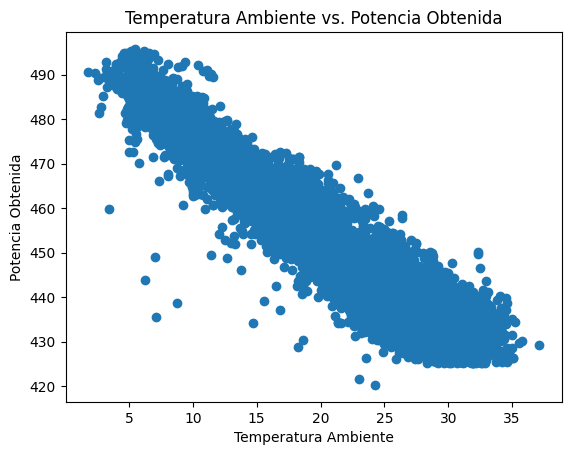

In [ ]:
plt.scatter(X[:,0],y)
plt.title('Temperatura Ambiente vs. Potencia Obtenida')
plt.xlabel('Temperatura Ambiente')
plt.ylabel('Potencia Obtenida')

Text(0, 0.5, 'Potencia Obtenida')

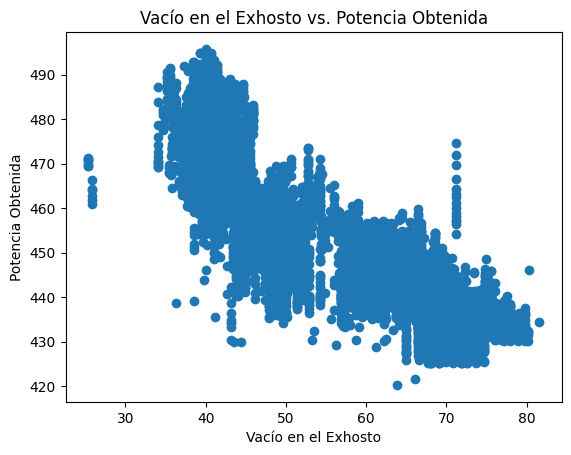

In [ ]:
plt.scatter(X[:,1],y)
plt.title('Vacío en el Exhosto vs. Potencia Obtenida')
plt.xlabel('Vacío en el Exhosto')
plt.ylabel('Potencia Obtenida')

In [ ]:
# Usamos la librería train_test_split de scikit learn para realizar la partición de los datos en datos de entrenamiento
# y datos de prueba; se usa el 80% de los datos para entrenamiento y el 20% restante para prueba

from sklearn.model_selection import train_test_split
[X_train,X_test,y_train,y_test] = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Usamos la librería StandardScaler para realizar una normalización de los datos, con el objetivo de facilitar el trabajo de la Red.
# La normalización consiste en restar cada dato por la media de todos y dividirlo entre la desviación estandar de todos.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
# Usamos el método np.newaxis para covertir la variable de salida en un Tensor

y_train = y_train[:,np.newaxis]

## Entrenamiento y Evaluación del Modelo

In [ ]:
# Entrenamiento de la Red

# Entrenamos una red con 2 neuronas en la entrada, 32 y 16 neuronas en las capas intermedias, 1 neurona de salida
network = [
    FCLayer(2, 32),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(32, 16),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(16,1)
]

epochs = 500  #Entrenamos el modelo con 500 epocas
learning_rate = 0.0001  # Usamos un learning rate de 0.0001

errors = []

# training
for epoch in range(epochs):
    error = 0
    for x, y_true in zip(X_train_sc, y_train):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # error (para propósitos de visualización)
        error += mse(y_true, output)  # Calculamos el error por MSE

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)
    
    error /= len(X_train_sc)
    errors.append(error)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))

1/500, error=5556.983152
2/500, error=62.228243
3/500, error=44.269749
4/500, error=34.415757
5/500, error=32.545937
6/500, error=31.850246
7/500, error=31.239504
8/500, error=30.858129
9/500, error=30.529353
10/500, error=30.222111
11/500, error=29.907901
12/500, error=29.608731
13/500, error=29.385810
14/500, error=29.143419
15/500, error=28.887060
16/500, error=28.678703
17/500, error=28.513369
18/500, error=28.370528
19/500, error=28.247335
20/500, error=28.141871
21/500, error=28.051029
22/500, error=27.972068
23/500, error=27.902913
24/500, error=27.840952
25/500, error=27.783381
26/500, error=27.728835
27/500, error=27.677733
28/500, error=27.631129
29/500, error=27.589795
30/500, error=27.553939
31/500, error=27.522812
32/500, error=27.494524
33/500, error=27.467432
34/500, error=27.441589
35/500, error=27.417976
36/500, error=27.397217
37/500, error=27.379324
38/500, error=27.363968
39/500, error=27.350728
40/500, error=27.339202
41/500, error=27.329037
42/500, error=27.319933

Text(0, 0.5, 'Error')

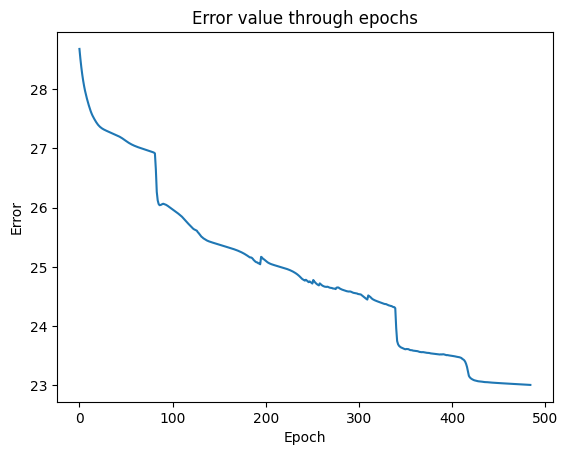

In [ ]:
plt.plot(errors[:][15:])
plt.title('Error value through epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')

In [ ]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

ratio = sum([np.argmax(y) == np.argmax(predict(network, x)) for x, y in zip(X_test_sc, y_test)]) / len(X_test_sc)
predict_error = sum([mse(y, predict(network, x)) for x, y in zip(X_test_sc, y_test)]) / len(X_test_sc)
print('ratio: %.2f' % ratio)
print('mse: %.4f' % predict_error)

ratio: 1.00
mse: 21.1915


## Resultados

In [ ]:
# Realizamos una predicción con los mismos datos de entrenamiento para realizar las gráficas de comparación

y_pred = predict(network, X_train_sc)
print(y_pred)

[[470.26364071]
 [463.57987652]
 [431.29282731]
 ...
 [463.26398349]
 [466.98035971]
 [429.75039551]]


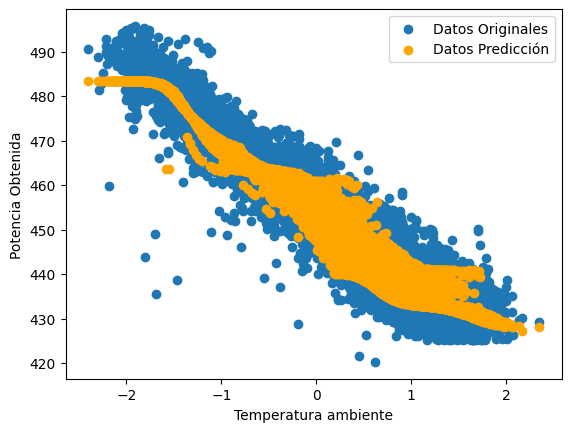

In [ ]:
plt.scatter(X_train_sc[:,0],y_train,label='Datos Originales')
plt.scatter(X_train_sc[:,0],y_pred,c='orange',label='Datos Predicción')
plt.xlabel('Temperatura ambiente')
plt.ylabel('Potencia Obtenida')
plt.legend(loc='upper right')

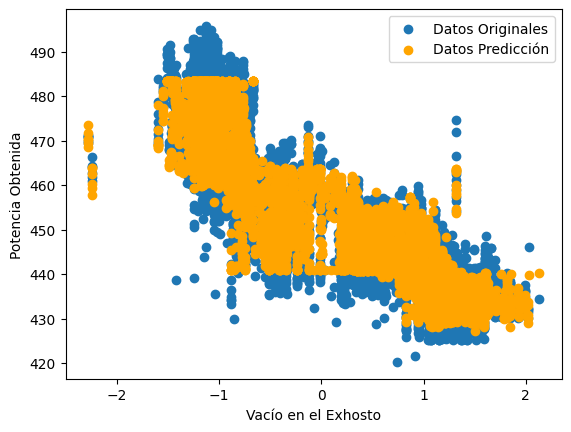

In [ ]:
plt.scatter(X_train_sc[:,1],y_train,label='Datos Originales')
plt.scatter(X_train_sc[:,1],y_pred,c='orange',label='Datos Predicción')
plt.xlabel('Vacío en el Exhosto')
plt.ylabel('Potencia Obtenida')
plt.legend(loc='upper right')